In [99]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn.linear_model import LogisticRegression #линейные моделиё
from sklearn.ensemble import RandomForestClassifier #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [100]:
R_STATE = 42

In [101]:
data = pd.read_csv("../data/_train_sem09 (1).csv")
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [102]:
data.shape

(3751, 1777)

In [103]:
X = data.drop('Activity', axis=1)
y = data['Activity']

c:\Users\mblyz\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Activity', ylabel='count'>

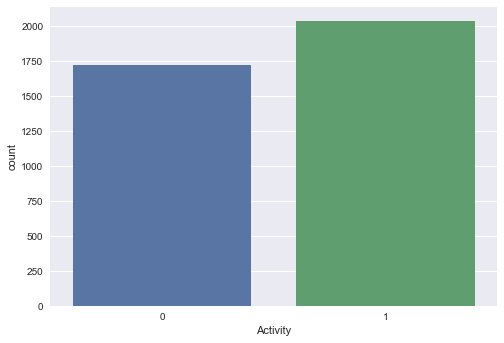

In [104]:
sns.countplot(y)

#### В целом, метки классов сбалансированны

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=R_STATE)

## 1. Подбираем гиперпараметры LogisticRegression четыремя методами

In [106]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
import optuna
from functools import partial

### 1.1 GridSearch

In [107]:
params_grid = [
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5]
    },
    { 
        'penalty': ['l2', None],
        'solver': ['lbfgs', 'newton-cg'],
        'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5]
    }
]

In [108]:
gs_log_reg = GridSearchCV(
    estimator=LogisticRegression(random_state=R_STATE, max_iter=1000),
    param_grid=params_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1'    
)
%time gs_log_reg.fit(X_train, y_train)
train_preds = gs_log_reg.predict(X_train)
test_preds = gs_log_reg.predict(X_test)
print(f"Найденные GSearch гиперпараметры, относительно метрики f1 score: {gs_log_reg.best_params_}")
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")


CPU times: total: 2.72 s
Wall time: 17min 27s
Найденные GSearch гиперпараметры, относительно метрики f1 score: {'C': 0.05, 'penalty': 'l2', 'solver': 'lbfgs'}
f1 score на тренировочной выборке: 0.8422344996930633
f1 score на тестовой выборке: 0.7926689576174113


### 1.2 RandomizedSearch

In [109]:
rs_log_reg = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=R_STATE, max_iter=1000),
    param_distributions=params_grid,
    n_iter=20,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
%time rs_log_reg.fit(X_train, y_train.values.ravel())
train_preds = rs_log_reg.predict(X_train)
test_preds = rs_log_reg.predict(X_test)
print(f"Найденные RSearch гиперпараметры, относительно метрики f1 score: {rs_log_reg.best_params_}")
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")


CPU times: total: 1.41 s
Wall time: 5min 44s
Найденные RSearch гиперпараметры, относительно метрики f1 score: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.05}
f1 score на тренировочной выборке: 0.8422344996930633
f1 score на тестовой выборке: 0.7926689576174113


### 1.3 Hyperopt

In [110]:
space = hp.choice('penalty_type',
                  [{
        'penalty': hp.choice('penalty_1', ['l1', 'l2']),
        'solver': hp.choice('solver_1', ['liblinear', 'saga']),
        'C': hp.uniform('C_1', 0.01, 1)
    },
    { 
        'penalty': hp.choice('penalty_2', ['l2', None]),
        'solver': hp.choice('solver_2', ['lbfgs', 'newton-cg', 'newton-cholesky']),
        'C': hp.uniform('C_2', 0.01, 1) # #hp.loguniform(label='C_2', low= -4*np.log(10), high=2*np.log(10))
    }]
)

In [111]:
def hyperpt_log_reg(params, X, y):
    model = LogisticRegression(**params, random_state=R_STATE, max_iter=1000)
    score = cross_val_score(estimator=model, X=X, y=y, cv=5, scoring='f1', n_jobs=-1).mean()
    return {'loss': -score, 'params': params, 'status': STATUS_OK}

In [112]:
trials = Trials()
best = fmin(
    fn=partial(hyperpt_log_reg, X=X_train, y=y_train),
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=20,
    rstate= np.random.default_rng(R_STATE)
)

100%|██████████| 20/20 [04:16<00:00, 12.84s/trial, best loss: -0.7861861865066677]


In [113]:
print(f"Найденные Hyperopt гиперпараметры, относительно метрики f1 score: {trials.best_trial['result']['params']}")

Найденные Hyperopt гиперпараметры, относительно метрики f1 score: {'C': 0.09092947253263425, 'penalty': 'l2', 'solver': 'newton-cholesky'}


In [114]:
model = LogisticRegression(**trials.best_trial['result']['params'], random_state=R_STATE, max_iter=1000)
model.fit(X_train,y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")

f1 score на тренировочной выборке: 0.8493402884320344
f1 score на тестовой выборке: 0.79498861047836


### 1.4 Optuna

In [115]:
def optuna_log_reg(trial: optuna.Trial, X, y):
    case = trial.suggest_categorical('case', [0,1])
    if case == 0:
        params = {
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
            'C': trial.suggest_float('C', 0.01, 1)
        }
    else:
        params = {
            'penalty': trial.suggest_categorical('penalty_1', ['l2', 'none']),
            'solver': trial.suggest_categorical('solver_1', ['lbfgs', 'newton-cg', 'newton-cholesky']),
            'C': trial.suggest_float('C_1', 0.01, 1)
        }
    model = LogisticRegression(**params, random_state=R_STATE, max_iter=1000)
    score = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='f1').mean()
    trial.set_user_attr('params', params)
    return score

In [116]:
study = optuna.create_study(
    study_name="Optuna_log_reg",
    direction='maximize'
)
study.optimize(
    func=partial(optuna_log_reg, X=X_train, y=y_train),
    n_trials=20,
)

[I 2023-05-26 22:19:48,193] A new study created in memory with name: Optuna_log_reg
[I 2023-05-26 22:20:12,651] Trial 0 finished with value: 0.7744929838884675 and parameters: {'case': 0, 'penalty': 'l2', 'solver': 'saga', 'C': 0.5120621092966768}. Best is trial 0 with value: 0.7744929838884675.
[I 2023-05-26 22:20:45,038] Trial 1 finished with value: 0.7250877932339528 and parameters: {'case': 1, 'penalty_1': 'none', 'solver_1': 'lbfgs', 'C_1': 0.5402058074239074}. Best is trial 0 with value: 0.7744929838884675.
[I 2023-05-26 22:20:51,617] Trial 2 finished with value: 0.7847146829783622 and parameters: {'case': 1, 'penalty_1': 'l2', 'solver_1': 'newton-cholesky', 'C_1': 0.06865068059904679}. Best is trial 2 with value: 0.7847146829783622.
[I 2023-05-26 22:20:59,325] Trial 3 finished with value: 0.7696349388342677 and parameters: {'case': 1, 'penalty_1': 'l2', 'solver_1': 'newton-cholesky', 'C_1': 0.8296454904034285}. Best is trial 2 with value: 0.7847146829783622.
[I 2023-05-26 22:21:

In [117]:
best_params = study.best_trial.user_attrs['params']
print(f"Найденные Optuna гиперпараметры, относительно метрики f1 score: {best_params}")

Найденные Optuna гиперпараметры, относительно метрики f1 score: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.03630746219949349}


In [118]:
model = LogisticRegression(**best_params, random_state=R_STATE, max_iter=1000)
model.fit(X_train,y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")

f1 score на тренировочной выборке: 0.8361858190709046
f1 score на тестовой выборке: 0.7990867579908676


## 2. Подбираем гиперпараметры RandomForestClassifer четыремя методами

### 2.1 GridSearch

In [119]:
params_grid = {
    'n_estimators': np.arange(100, 301, 100),
    'max_depth': np.arange(10, 26, 5),
    'min_samples_leaf': np.arange(3, 13, 3)
}

In [120]:
gs_rforest = GridSearchCV(
    estimator=RandomForestClassifier(random_state=R_STATE),
    param_grid=params_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1'
)
%time gs_rforest.fit(X_train, y_train)
train_preds = gs_rforest.predict(X_train)
test_preds = gs_rforest.predict(X_test)
print(f"Найденные GSearch гиперпараметры, относительно метрики f1 score: {gs_rforest.best_params_}")
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")


CPU times: total: 6.2 s
Wall time: 2min 20s
Найденные GSearch гиперпараметры, относительно метрики f1 score: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 300}
f1 score на тренировочной выборке: 0.9732420659614188
f1 score на тестовой выборке: 0.8375870069605568


### 2.2 RandomizedSearch

In [121]:
rs_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=R_STATE),
    param_distributions=params_grid,
    cv=5, 
    n_jobs=-1,
    n_iter=20,
    scoring='f1',
    random_state=R_STATE
)
%time rs_forest.fit(X_train, y_train)
train_preds = rs_forest.predict(X_train)
test_preds = rs_forest.predict(X_test)
print(f"Найденные RSearch гиперпараметры, относительно метрики f1 score: {rs_forest.best_params_}")
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")

CPU times: total: 5.06 s
Wall time: 55.3 s
Найденные RSearch гиперпараметры, относительно метрики f1 score: {'n_estimators': 300, 'min_samples_leaf': 3, 'max_depth': 20}
f1 score на тренировочной выборке: 0.9732420659614188
f1 score на тестовой выборке: 0.8375870069605568


### 2.3 Hyperopt

In [122]:
space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
    'max_depth': hp.quniform('max_depth', 10, 25, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 12, 2)
}

In [123]:
def hyperpt_rforest(params, X, y):
    params_int = {key: int(params[key]) for key in params.keys() if key != 'criterion'}
    params_int['criterion'] = params['criterion']
    model = RandomForestClassifier(**params_int, random_state=R_STATE)
    score = cross_val_score(model, X, y, scoring='f1', cv=5, n_jobs=-1).mean()
    return {'loss': -score, 'params': params_int, 'status': STATUS_OK}

In [124]:
trials = Trials()
best = fmin(
    fn=partial(hyperpt_rforest, X=X_train, y=y_train),
    max_evals=20,
    trials=trials,
    space=space,
    rstate=np.random.default_rng(R_STATE)
)

TPE is being used as the default algorithm.


100%|██████████| 20/20 [01:09<00:00,  3.49s/trial, best loss: -0.8062003307934382]


In [125]:
best_params = trials.best_trial['result']['params']
print(f"Найденные Hyperopt гиперпараметры, относительно метрики f1 score: {best_params}")

Найденные Hyperopt гиперпараметры, относительно метрики f1 score: {'max_depth': 19, 'min_samples_leaf': 4, 'n_estimators': 130, 'criterion': 'entropy'}


In [126]:
model = RandomForestClassifier(**best_params, random_state=R_STATE)
model.fit(X_train,y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")

f1 score на тренировочной выборке: 0.9605467536502019
f1 score на тестовой выборке: 0.8321839080459771


### 2.4 Optuna

In [127]:
def optuna_forest(trial: optuna.Trial, X, y):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, 10),
        'max_depth': trial.suggest_int('max_depth', 10, 25, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 13, 2)
    }
    model = RandomForestClassifier(**params, random_state=R_STATE)
    score = cross_val_score(model, X, y, scoring='f1', n_jobs=-1, cv=5).mean()
    return score

In [128]:
study = optuna.create_study(
    study_name='random_forest_optuna',
    direction='maximize',
)
study.optimize(
    func=partial(optuna_forest, X=X_train, y=y_train),
    n_trials=20,
    show_progress_bar=True
)

[I 2023-05-26 22:39:07,584] A new study created in memory with name: random_forest_optuna
c:\Users\mblyz\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-05-26 22:39:10,557] Trial 0 finished with value: 0.7970879707323579 and parameters: {'criterion': 'entropy', 'n_estimators': 150, 'max_depth': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7970879707323579.
[I 2023-05-26 22:39:13,127] Trial 1 finished with value: 0.804631994301371 and parameters: {'criterion': 'gini', 'n_estimators': 100, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.804631994301371.
[I 2023-05-26 22:39:15,238] Trial 2 finished with value: 0.7958067892766543 and parameters: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.804631994301371.
[I 2023-05-26 22:39:20,570] Trial 3 finished with value: 0.7989577104556662 and parameters: {'criterion': 'gini', 'n_estimators': 270, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.804631994301371.
[I 2023-05-26 22:39:25,910] Trial 4 finished with value: 0.7940666763317081 and parameters: {'criterio

In [129]:
print(f"Наилучшая комбинация гиперпараметров, относительно метрики f1 score: {study.best_params}")

Наилучшая комбинация гиперпараметров, относительно метрики f1 score: {'criterion': 'gini', 'n_estimators': 240, 'max_depth': 16, 'min_samples_leaf': 3}


In [130]:
model = RandomForestClassifier(**study.best_params, random_state=R_STATE)
model.fit(X_train,y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f"f1 score на тренировочной выборке: {metrics.f1_score(y_train, train_preds)}")
print(f"f1 score на тестовой выборке: {metrics.f1_score(y_test, test_preds)}")

f1 score на тренировочной выборке: 0.964874106310227
f1 score на тестовой выборке: 0.8389339513325608


In [135]:
optuna.visualization.plot_optimization_history(study, target_name='f1 score')

In [137]:
optuna.visualization.plot_param_importances(study, target_name='f1 score')

In [138]:
optuna.visualization.plot_contour(study, params=['min_samples_leaf', 'max_depth'], target_name='f1 score')